### Segmenting and Clustering Neighborhoods in Toronto - Part 3

#### This notebook is to explore and cluster the neighborhoods in Toronto perform analysis and report observations

In [11]:
#importing libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: / 
  - anaconda/linux-64::ca-certificates-2020.1.1-0, anaconda/linux-64::certifi-2019.11.28-py37_0, anaconda/linux-64::openssl-1.1.1d-h7b6447c_4
  - anaconda/linux-64::ca-certificates-2020.1.1-0, anaconda/linux-64::certifi-2019.11.28-py37_0, defaults/linux-64::openssl-1.1.1d-h7b6447c_4
  - anaconda/linux-64::ca-certificates-2020.1.1-0, anaconda/linux-64::openssl-1.1.1d-h7b6447c_4, defaults/linux-64::certifi-2019.11.28-py37_0
  - anaconda/linux-64::ca-certificates-2020.1.1-0, defaults/linux-64::certifi-2019.11.28-py37_0, defaults/linux-64::openssl-1.1.1d-h7b6447c_4
  - anaconda/linux-64::openssl-1.1.1d-h7b6447c_4, defaults/linux-64::ca-certificates-2020.1.1-0, defaults/linux-64::certifi-2019.11.28-py37_0
  - defaults/linux-64::ca-certificates-2020.1.1-0, defaults/linux-64::certifi-2019.11.28-py37_0, defaults/linux-64::openssl-1.1.1d-h7b6447c_4
  - anaconda/linux-64::certifi-2019.11.28-py37_0, anaconda/linux-64::openssl-1.1.1d-h7b6447c_4, defaults/linux-64::ca-certif

#### Read in the CSV file from the second assignment notebook

In [12]:
link = "https://raw.githubusercontent.com/gaurav1984-DS/Coursera_Capstone/master/df_2.csv"
neighborhoods = pd.read_csv(link,index_col=0)

neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [14]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Visualizing Toronto map

In [16]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [17]:
# Define Foursquare Credentials and Version
LIMIT = 100

CLIENT_ID = '4TWLVWSSVJKC4DNDVBGEV0HKUSB1JUVWU3XXTMRHKT1NW5BG' # your Foursquare ID
CLIENT_SECRET = 'QMSAWI3MWIOMEIDGADANUVLI0X3ZYPRI2VGNX3CYOWOOGSS4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4TWLVWSSVJKC4DNDVBGEV0HKUSB1JUVWU3XXTMRHKT1NW5BG
CLIENT_SECRET:QMSAWI3MWIOMEIDGADANUVLI0X3ZYPRI2VGNX3CYOWOOGSS4


### Fuction to explore neighborhoods in Toronto

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called toronto_venues

In [20]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [21]:
# checkout the new dataframe
toronto_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [22]:
#dimensions of new dataframe
toronto_venues.shape


(2118, 7)

In [23]:
# no. of venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17


In [24]:
#unique categories from all the returned venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 273 uniques categories.


#### Hot encode to analyze each neighborhood and create new dataframe

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [26]:
# Examine the new data frame
toronto_onehot.shape

(2118, 273)

#### Grouping rows by neighborhood and on basis of the mean of the frequency of each category

In [27]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [28]:
# confirm the new size
toronto_grouped.shape

(96, 273)

#### Each neighborhood with the top 5 most common venues

In [29]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0               Skating Rink   0.2
1                     Lounge   0.2
2             Breakfast Spot   0.2
3  Latin American Restaurant   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.25
1            Pharmacy  0.12
2                 Gym  0.12
3      Sandwich Place  0.12
4  Athletics & Sports  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
                 venue  freq
0                 Bank  0.11
1          Coffee Shop  0.11
2       Ice Cream Shop  0.05
3     Sushi Restaurant  0.05
4  Fried Chicken Joint  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4                Motel  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2         C

#### Sorting the venues in descending order

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating new dataframe to show top 10 venues for each neighborhood

In [78]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Skating Rink,Clothing Store,Lounge,Latin American Restaurant,Eastern European Restaurant,Electronics Store,Drugstore,Donut Shop,Department Store
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Gym,Athletics & Sports,Pharmacy,Pub,Sandwich Place,Dim Sum Restaurant,Deli / Bodega,Department Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Bridal Shop,Supermarket,Ice Cream Shop,Middle Eastern Restaurant,Restaurant,Mobile Phone Shop,Fried Chicken Joint,Deli / Bodega
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Women's Store,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Restaurant,Coffee Shop,Cupcake Shop,Pharmacy,Liquor Store,Juice Bar,Indian Restaurant,Pub


#### To determine best no. of clusters on basis of determining the inertia within cluster

#### We will plot for Distortion vs No. of clusters and look for a forming of an elbow this will be the point where change in cluster doesn't afftect much change in distortion

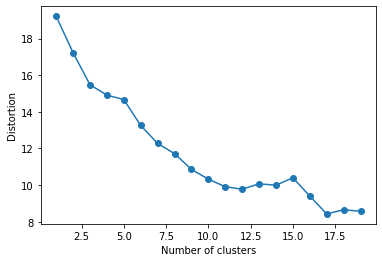

In [79]:
import matplotlib.pyplot as plt
# calculate distortion for a range of number of cluster
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=500,
        tol=1e-04, random_state=0
    )
    km.fit(toronto_grouped_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

#### Plot of Distortion vs Number of clusters is not quite clear in providing the best number, we will now look for silhouette score to help us determine best number of cluster

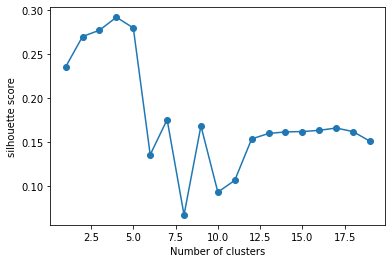

In [102]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for i in range(2, kmax+1):
  kmeans = KMeans(n_clusters=i,random_state=1).fit(toronto_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))

# plot
plt.plot(range(1, 20), sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.show()

#### Silhouette score tells how far away the datapoints in one cluster are, from the datapoints in another cluster. The range of silhouette score is from -1 to 1. Score should be closer to 1 than -1

#### Silhouette score shows that best number of clusters is 4

#### Run k-means to cluster the neighborhood into 4 clusters.



In [82]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,init='random', n_init=10, max_iter=500, tol=1e-04, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0], dtype=int32)

#### Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [83]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how = 'right')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Park,Food & Drink Shop,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,Pizza Place,Intersection,Portuguese Restaurant,French Restaurant,Coffee Shop,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Café,Breakfast Spot,Theater,Event Space,Bank,French Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Event Space,Coffee Shop,Furniture / Home Store,Miscellaneous Shop,Boutique,Sporting Goods Shop,Vietnamese Restaurant,Accessories Store,Drugstore
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Diner,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Italian Restaurant,Smoothie Shop,Sandwich Place,Distribution Center


In [85]:
toronto_merged.groupby('Cluster Labels').count()


,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57
1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
3,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31


### Visualizing the clusters

In [99]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### Cluster 1

In [101]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Hockey Arena,Pizza Place,Intersection,Portuguese Restaurant,French Restaurant,Coffee Shop,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Café,Breakfast Spot,Theater,Event Space,Bank,French Restaurant
3,North York,0,Clothing Store,Event Space,Coffee Shop,Furniture / Home Store,Miscellaneous Shop,Boutique,Sporting Goods Shop,Vietnamese Restaurant,Accessories Store,Drugstore
4,Downtown Toronto,0,Coffee Shop,Diner,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Italian Restaurant,Smoothie Shop,Sandwich Place,Distribution Center
7,North York,0,Gym,Asian Restaurant,Japanese Restaurant,Restaurant,Beer Store,Coffee Shop,Clothing Store,Italian Restaurant,Supermarket,Discount Store
13,North York,0,Gym,Asian Restaurant,Japanese Restaurant,Restaurant,Beer Store,Coffee Shop,Clothing Store,Italian Restaurant,Supermarket,Discount Store
9,Downtown Toronto,0,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Café,Japanese Restaurant,Diner,Italian Restaurant,Bookstore
10,North York,0,Japanese Restaurant,Park,Asian Restaurant,Pub,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
15,Downtown Toronto,0,Café,Coffee Shop,Gastropub,Restaurant,Cocktail Bar,American Restaurant,Gym,Italian Restaurant,Japanese Restaurant,Lingerie Store
17,Etobicoke,0,Café,Beer Store,Pet Store,Pharmacy,Pizza Place,Coffee Shop,Liquor Store,Women's Store,Discount Store,Department Store


#### Cluster 2

In [90]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,1,Baseball Field,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,Farmers Market
101,Etobicoke,1,Baseball Field,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,Farmers Market


#### Cluster 3

In [91]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,Park,Food & Drink Shop,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
21,York,2,Park,Pool,Women's Store,Greek Restaurant,Cupcake Shop,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
35,East York,2,Park,Convenience Store,Coffee Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
49,North York,2,Park,Bakery,Basketball Court,Construction & Landscaping,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
61,Central Toronto,2,Park,Construction & Landscaping,Swim School,Bus Line,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Electronics Store,Deli / Bodega
64,York,2,Convenience Store,Park,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
66,North York,2,Convenience Store,Park,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
85,Scarborough,2,Park,Playground,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
91,Downtown Toronto,2,Park,Playground,Trail,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
98,Etobicoke,2,River,Smoke Shop,Park,College Rec Center,College Stadium,Electronics Store,Eastern European Restaurant,Drugstore,College Gym,Donut Shop


#### Cluster 4

In [92]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,3,Fast Food Restaurant,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Falafel Restaurant
8,East York,3,Pizza Place,Gym / Fitness Center,Fast Food Restaurant,Breakfast Spot,Pharmacy,Bank,Athletics & Sports,Intersection,Café,Gastropub
11,Etobicoke,3,Filipino Restaurant,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
12,Scarborough,3,Home Service,Bar,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
14,East York,3,Park,Bus Stop,Beer Store,Skating Rink,Curling Ice,Pharmacy,College Stadium,Deli / Bodega,Eastern European Restaurant,College Gym
16,York,3,Hockey Arena,Tennis Court,Field,Trail,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
19,East Toronto,3,Health Food Store,Pub,Trail,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
26,Scarborough,3,Hakka Restaurant,Caribbean Restaurant,Athletics & Sports,Bakery,Thai Restaurant,Bank,Gas Station,Fried Chicken Joint,Dog Run,Distribution Center
27,North York,3,Pool,Golf Course,Dog Run,Mediterranean Restaurant,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
31,West Toronto,3,Bakery,Pharmacy,Café,Brewery,Bank,Bar,Supermarket,Music Venue,Middle Eastern Restaurant,Grocery Store


 ### Observation

#### Cluster 1 is very large with restuarant, coffee shops, cafe and bar, it should be best suited for peoople who enjoy eating out on regular basis
#### Cluster 2  is  very small with only two borough and both have completely same profile
#### Cluster 3  have borough with Park, Playground being one of most common venues, should be best suited for people who enjoy outdoor
#### Cluster 4  doesn’t appear to include boroughs that are very smiliar, will require further analysis